In [25]:
import os
import tempfile
from pdf2image import convert_from_path
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.pyplot import imshow
import pytesseract
import re
import imutils
import random
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tqdm import tqdm
import pyocr
import pyocr.builders

### Сделаем из наших pdf- jpg, разделив при этом на страницы

In [42]:
def convert_pdf(in_path,image_name ,output_path):
    images = convert_from_path(in_path+image_name)
    for i in range(len(images)):
        images[i].save(output_path+'/'+image_name[:-4]+str(i)+'.jpg')

In [ ]:
for pdf in os.listdir("данные"):
    convert_pdf('данные/',pdf, 'temp')

### Я поссмотрел - вроде как все картинки изначально в правильном положении. 
#### Сгенерим случайный вращения

In [4]:
rotation=[random.choice([0,90,270,180]) for x in range(len(os.listdir("temp")))]

In [4]:
#my_df = pd.DataFrame(rotation)
#my_df.to_csv('my_csv.csv', index=False, header=False)
rotation=np.array(pd.read_csv('my_csv.csv',header=None)[0])

In [5]:
rotation.shape

(1770,)

#### Повернем на сгененрированный градус и честно сохраним в папочку

In [6]:
for im,rotate in zip(os.listdir("temp"),rotation):
    image=cv2.imread('temp/'+im)
    # rotate_bound - используем чтобы при повороте не обрезать часть текста
    rotated = imutils.rotate_bound(image, rotate)
    Image.fromarray(rotated).save('temp_rotated/'+im)
    

### Попробуем метод  image_to_osd из Pytesseract

In [20]:
angles_pytesseract=[]
for im in tqdm(os.listdir("temp_rotated/")):
    try:        
        rot_data = pytesseract.image_to_osd(Image.open('temp_rotated/'+im))
        rot = re.search('(?<=Rotate: )\d+', rot_data).group(0)
        angle = float(rot)
        if angle > 0:
            angle = 360 - angle
        angles_pytesseract.append(angle)    
    except:
        # На каких-то файлах метод выпадает, сообщая что 
        # не может опереться на достаточное число символов
        # будем честно заприсывать заранее неверное значение
        angles_pytesseract.append(1000)
    

100%|██████████| 1770/1770 [31:27<00:00,  1.07s/it]


In [38]:
#angles_pytesseract = pd.DataFrame(angles_pytesseract)
#angles_pytesseract.to_csv('angles_pytesseract', index=False, header=False)

In [12]:
angles_pytesseract=np.array(pd.read_csv('angles_pytesseract',header=None)[0])

In [13]:
wrong_index_pytesseract=np.where(np.array(angles_pytesseract,dtype = np.int32)!=np.array(rotation))[0]

In [14]:
# 49 оп повернул неверно
wrong_index_pytesseract.shape

(49,)

In [15]:
accuracy_score(rotation,angles_pytesseract)

0.9723163841807909

In [16]:
f1_score(rotation,angles_pytesseract, average='macro')

0.7798510457100666

#### Посмотрим на пару неверных примеров

Уракчиев2.jpg
90 1000
Определение Колотилина2.jpg
180 0.0
Определение по дате1.jpg
90 1000
Соболев2.jpg
180 0.0


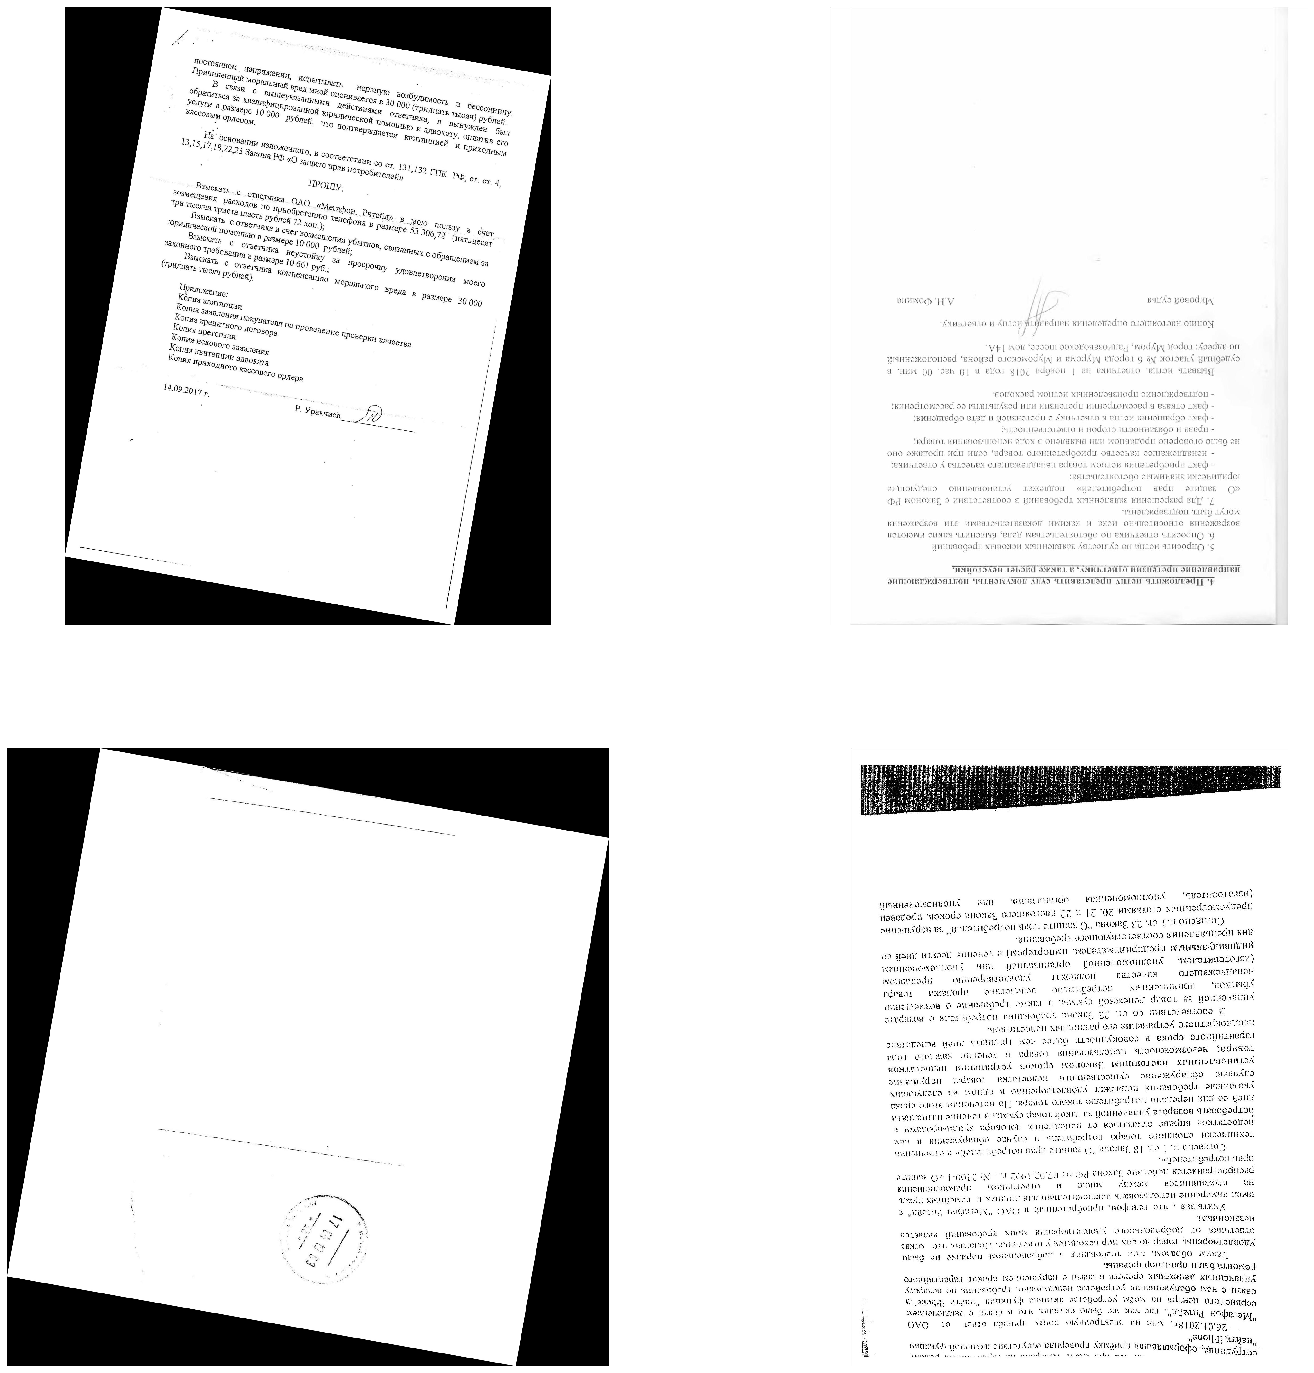

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(25, 25))

for i in range(4):
    print(os.listdir("temp_rotated/")[wrong_index_pytesseract[i]])
    print(rotation[wrong_index_pytesseract[i]],angles_pytesseract[wrong_index_pytesseract[i]])
    image=cv2.imread('temp_rotated/'+os.listdir("temp_rotated/")[wrong_index_pytesseract[i]])
    rotated = imutils.rotate_bound(image, angles_pytesseract[wrong_index_pytesseract[i]])
    ax[i//2,i%2].imshow(rotated, cmap='gray')
    ax[i//2,i%2].axis('off')

#### Вообще выглядят читабельно, все кроме третьей

### Попробуем Pyocr
#### Вот  тут говоорится, что он получше справляется: https://medium.com/@winston.smith.spb/python-ocr-for-pdf-or-compare-textract-pytesseract-and-pyocr-acb19122f38c

In [5]:

tools = pyocr.get_available_tools()
if len(tools) == 0:
    print("No OCR tool found")
    sys.exit(1)
# The tools are returned in the recommended order of usage
tool = tools[0]

In [6]:
angles_pyocr_2=[]

for im in tqdm(os.listdir("temp_rotated/")):
    try:
        orientation = tool.detect_orientation(Image.open('temp_rotated/'+im),lang='rus')
        angles_pyocr_2.append(orientation['angle'])

    except:
        angles_pyocr_2.append(1000)



100%|██████████| 1770/1770 [28:59<00:00,  1.02it/s]


In [41]:
#angles_pyocr = pd.DataFrame(angles_pyocr_2)
#angles_pyocr.to_csv('angles_pyocr', index=False, header=False)

In [18]:
angles_pyocr_2=np.array(pd.read_csv('angles_pyocr',header=None)[0])

In [19]:
accuracy_score(rotation,angles_pyocr_2)

0.9711864406779661

In [20]:
# F1 для pyocr
f1_score(rotation,angles_pyocr_2, average='macro')

0.7787393378590542

In [21]:
# F1 для pytesseract
f1_score(rotation,angles_pytesseract, average='macro')

0.7798510457100666

Уракчиев2.jpg
90 0
Определение Колотилина2.jpg
180 1000
Определение по дате1.jpg
90 0
Соболев2.jpg
180 0


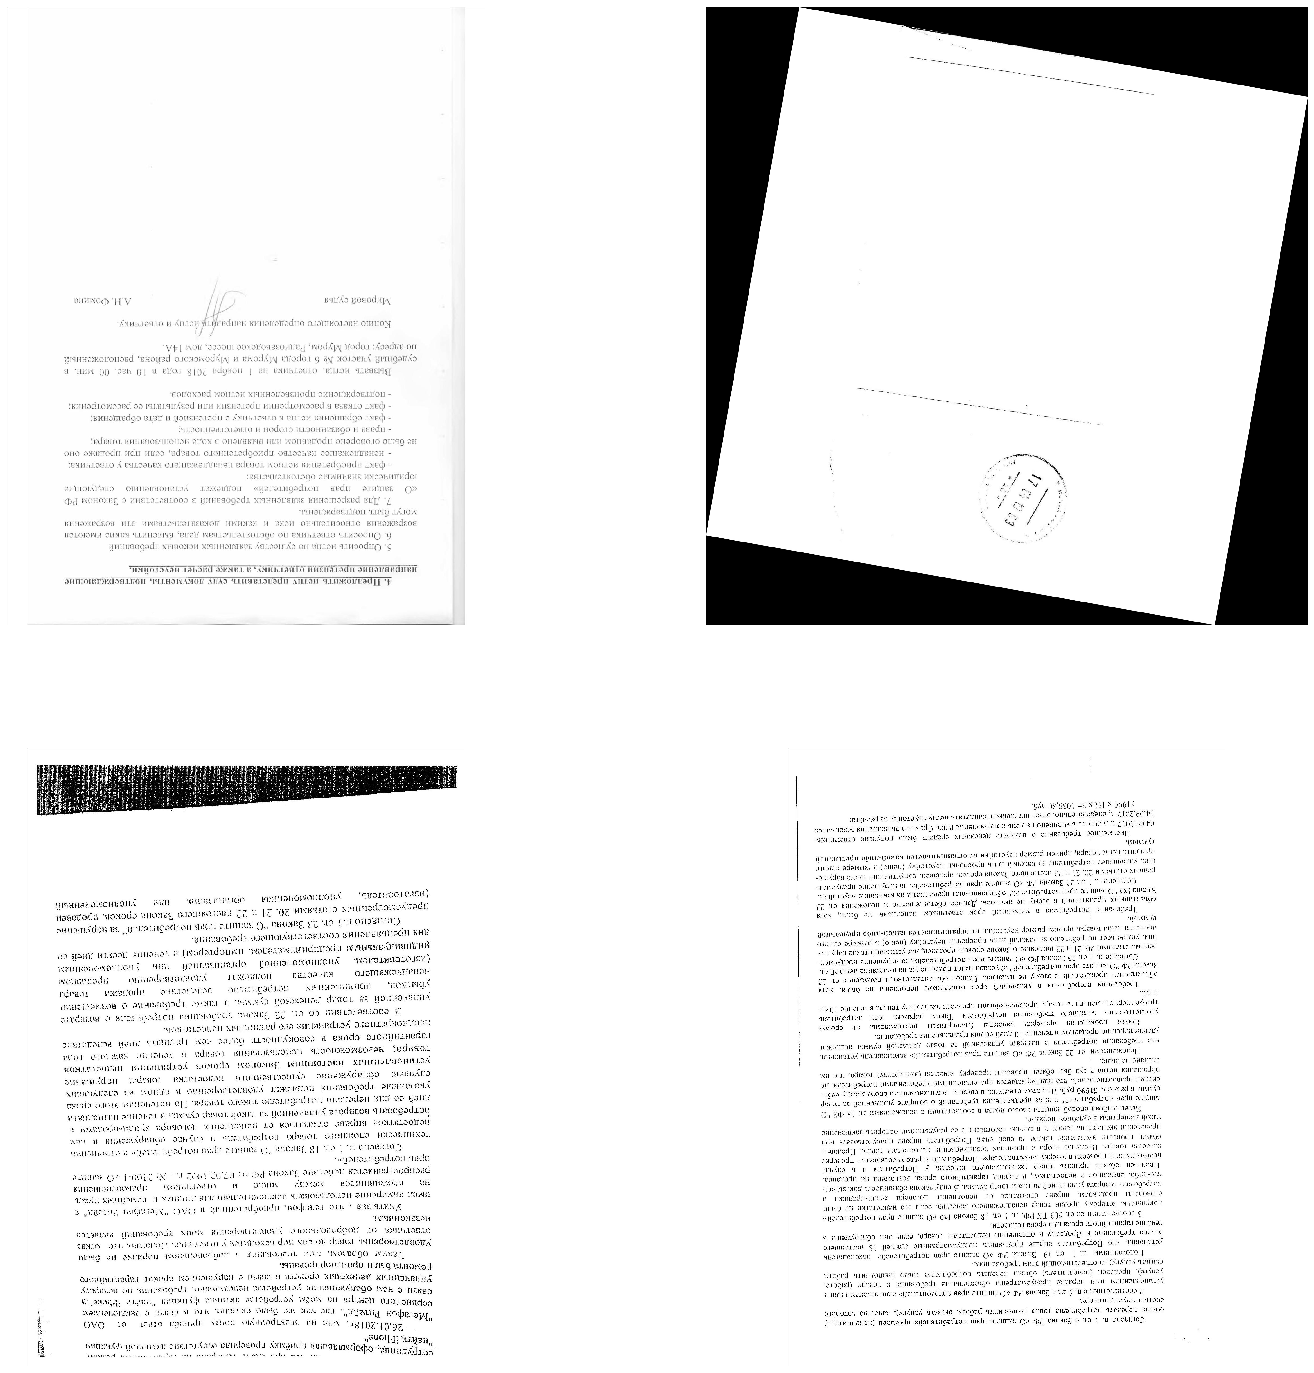

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(25, 25))

for i in range(4):
    print(os.listdir("temp_rotated/")[wrong_index_pytesseract[i]])
    print(rotation[wrong_index_pytesseract[i]],angles_pyocr_2[wrong_index_pyocr[i]])
    image=cv2.imread('temp_rotated/'+os.listdir("temp_rotated/")[wrong_index_pyocr[i]])
    rotated = imutils.rotate_bound(image, angles_pyocr_2[wrong_index_pyocr[i]])
    ax[i//2,i%2].imshow(rotated, cmap='gray')
    ax[i//2,i%2].axis('off')

#### Зададимся вопросом- Может их как-то покомбиноровать

In [22]:
wrong_index_pyocr=np.where(np.array(angles_pyocr_2,dtype = np.int32)!=np.array(rotation))[0]

In [23]:
print(wrong_index_pyocr)
print(wrong_index_pyocr.shape)

[  50   53   67  106  157  165  191  204  240  250  272  317  358  417
  476  578  598  639  656  657  661  664  778  781  800  835  882  900
  933  955  963  979 1000 1118 1135 1144 1150 1170 1187 1200 1210 1223
 1235 1257 1267 1318 1399 1489 1500 1548 1700]
(51,)


In [32]:
print(wrong_index_pytesseract)
print(wrong_index_pytesseract.shape)

[  12   50   53   67  106  157  165  204  240  250  272  317  358  417
  476  578  589  598  639  656  657  661  664  781  800  835  882  900
  933  955  963  979 1000 1118 1135 1144 1170 1200 1210 1223 1235 1257
 1267 1318 1399 1489 1500 1548 1700]
(49,)


#### Видно, что ошибаются они в одних и  тех же местах 
#### Сосственно 47 ошибок у них  общих

In [30]:
len( [x for x in wrong_index_pyocr if x in wrong_index_pytesseract])

47

#### При pytesseract немного точнее, хотя чаще, вообще ничего не отдает

In [48]:
np.where(np.array(angles_pyocr_2,dtype = np.int32)==1000)[0].shape

(8,)

In [49]:
np.where(np.array(wrong_index_pyocr,dtype = np.int32)==1000)[0].shape

(1,)

#### Еще наблюдения:
* Препроцессинг ( по крайней мере из того, что я успел попробовать erode,dilate,remove_noise,opening) пока только ухудшал результаты, может быть стоит пробовать еще какие-то варианты
* "Наивные" методы из cv2 ( https://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/) работают хуже, чем random
* Предобученный EAST: An Efficient and Accurate Scene Text Detector из cv2,также показывает неудволетворительные результаты на нашем сете
* Что еще можно поделать:
#### 1) Поиграть еще с препроцессингом
#### 2) Поискать еще методы , поансамблитровать их с pytesseract или pyocr (тем более они какой-то confidence возвращают)